# Prediction of Stock Price Direction
source: https://platform.stratascratch.com/data-projects/prediction-stock-price-direction

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, ConciseDateFormatter
from matplotlib.ticker import MultipleLocator
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay


In [3]:
train = pd.read_csv("./datasets/AMZN_train.csv")
val = pd.read_csv("./datasets/AMZN_val.csv")
test = pd.read_csv("./datasets/AMZN_test.csv")

In [4]:
train.info()
val.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4781 non-null   object 
 1   Open       4781 non-null   float64
 2   High       4781 non-null   float64
 3   Low        4781 non-null   float64
 4   Close      4781 non-null   float64
 5   Adj Close  4781 non-null   float64
 6   Volume     4781 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 261.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       503 non-null    object 
 1   Open       503 non-null    float64
 2   High       503 non-null    float64
 3   Low        503 non-null    float64
 4   Close      503 non-null    float64
 5   Adj Close  503 non-null    float64
 6   Volume     503 non-null    int64  
dtypes

## (1) Feature engineering

In [5]:
def longest_streak_of_ones(arr):
    """
    Given a numpy array of 0s and 1s, return the length of the longest consecutive run of 1s.
    """
    max_streak = 0
    current_streak = 0
    for val in arr:
        if val == 1:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

In [6]:
def dataCleansing(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)
    df["direction"] = np.where(df["Adj Close"] > df["Adj Close"].shift(1), 1, 0)
    df["hi_low_gap_1d"] = df["High"].shift(1).max() / df["Low"].shift(1).min()
    df["hi_low_gap_3d"] = (
        df["High"].shift(1).rolling(3).max() / df["Low"].shift(1).rolling(3).min()
    )
    df["hi_low_gap_7d"] = (
        df["High"].shift(1).rolling(7).max() / df["Low"].shift(1).rolling(7).min()
    )
    df["hi_low_gap_14d"] = (
        df["High"].shift(1).rolling(14).max() / df["Low"].shift(1).rolling(14).min()
    )
    df["up_streak_1d"] = df["direction"].shift(1)
    df["up_streak_3d"] = (
        df["direction"].shift(1).rolling(3).apply(longest_streak_of_ones)
    )
    df["up_streak_7d"] = (
        df["direction"].shift(1).rolling(7).apply(longest_streak_of_ones)
    )
    df["up_streak_14d"] = (
        df["direction"].shift(1).rolling(14).apply(longest_streak_of_ones)
    )
    df["up_streak_21d"] = (
        df["direction"].shift(1).rolling(21).apply(longest_streak_of_ones)
    )
    df["close_chg_2d"] = df["Adj Close"].shift(1) / df["Adj Close"].shift(2)
    df["close_chg_3d"] = df["Adj Close"].shift(1) / df["Adj Close"].shift(3)
    df["close_chg_7d"] = df["Adj Close"].shift(1) / df["Adj Close"].shift(7)
    df["close_chg_14d"] = df["Adj Close"].shift(1) / df["Adj Close"].shift(14)
    df["vol_chg_2d"] = df["Volume"].shift(1) / df["Volume"].shift(2)
    df["vol_chg_3d"] = df["Volume"].shift(1) / df["Volume"].shift(3)
    df["vol_chg_7d"] = df["Volume"].shift(1) / df["Volume"].shift(7)
    df["vol_chg_14d"] = df["Volume"].shift(1) / df["Volume"].shift(14)
    df["direction_3d"] = np.where(
        df["Adj Close"].shift(1) > df["Adj Close"].shift(3), 1, 0
    )
    df["direction_7d"] = np.where(
        df["Adj Close"].shift(1) > df["Adj Close"].shift(7), 1, 0
    )
    df["direction_14d"] = np.where(
        df["Adj Close"].shift(1) > df["Adj Close"].shift(14), 1, 0
    )
    df["up_freq_3d"] = df["direction"].shift(1).rolling(3).mean()
    df["up_freq_7d"] = df["direction"].shift(1).rolling(7).mean()
    df["up_freq_14d"] = df["direction"].shift(1).rolling(14).mean()

    return df


train = dataCleansing(train)
val = dataCleansing(val)
test = dataCleansing(test)

In [7]:
var_0 = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume", "direction"]
var_hi_low_gap = train.filter(regex="hi_low_gap").columns.to_list()
var_up_streak = train.filter(regex="up_streak").columns.to_list()
var_close_chg = train.filter(regex="close_chg").columns.to_list()

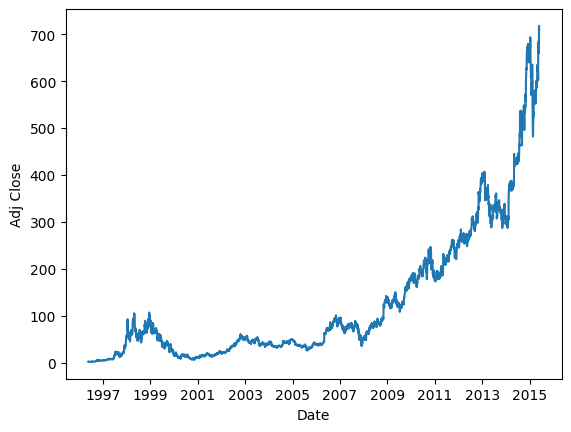

In [8]:
sns.lineplot(x="Date", y="Adj Close", data=train)

plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(MultipleLocator(365 * 2))

## (2) xGBoost

In [9]:
train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'direction', 'hi_low_gap_1d', 'hi_low_gap_3d', 'hi_low_gap_7d',
       'hi_low_gap_14d', 'up_streak_1d', 'up_streak_3d', 'up_streak_7d',
       'up_streak_14d', 'up_streak_21d', 'close_chg_2d', 'close_chg_3d',
       'close_chg_7d', 'close_chg_14d', 'vol_chg_2d', 'vol_chg_3d',
       'vol_chg_7d', 'vol_chg_14d', 'direction_3d', 'direction_7d',
       'direction_14d', 'up_freq_3d', 'up_freq_7d', 'up_freq_14d'],
      dtype='object')

In [10]:
preds = [
    i
    for i in train.columns
    if i
    not in ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume", "direction"]
]
target = "direction"

In [11]:
X_train = train[preds]
y_train = train[target]
X_val = val[preds]
y_val = val[target]
X_test = test[preds]
y_test = test[target]

In [27]:
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.15],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
}

cv = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=77),
    param_distributions=param_dist,
    n_iter=80,  # Number of parameter settings to try
    scoring="accuracy",  # Or another appropriate scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Print out progress messages
    random_state=88,  # For reproducibility
    n_jobs=-1,  # Use all available cores
)

cv.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=77, ...),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=88, scoring='accuracy', verbose=1)

In [28]:
print(cv.best_params_)
print(cv.best_score_)


{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
0.5076315018603289


Finetune n_estimators with early stopping 

In [49]:
xgb_clf2 = XGBClassifier(
    **{
        "subsample": 0.8,
        "n_estimators": 500,
        "min_child_weight": 3,
        "max_depth": 4,
        "learning_rate": 0.1,
        "gamma": 0,
        "colsample_bytree": 0.8,
        "early_stopping_rounds": 50,
        "eval_metric": "auc",
        "random_state": 77,
    }
)

xgb_clf2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)

[0]	validation_0-auc:0.50821
[50]	validation_0-auc:0.53534
[100]	validation_0-auc:0.56032
[150]	validation_0-auc:0.56549
[168]	validation_0-auc:0.56583


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=77, ...)

In [50]:
print(xgb_clf2.best_iteration)

119


In [51]:
roc_auc_score(y_test, xgb_clf2.predict(X_test))

0.537665740373164

## (3) Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

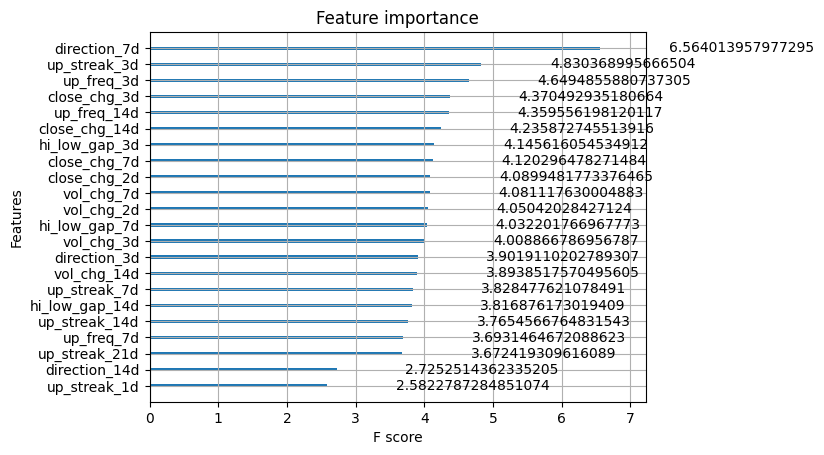

In [65]:
# feature_importance = pd.DataFrame(
#     {"feature": X_train.columns, "importance": xgb_clf2.feature_importances_}
# )
# feature_importance.sort_values("importance", ascending=False)
xgb.plot_importance(xgb_clf2, importance_type="gain")

## (4) Model interpretation

In [69]:
shap.__version__

'0.46.0'

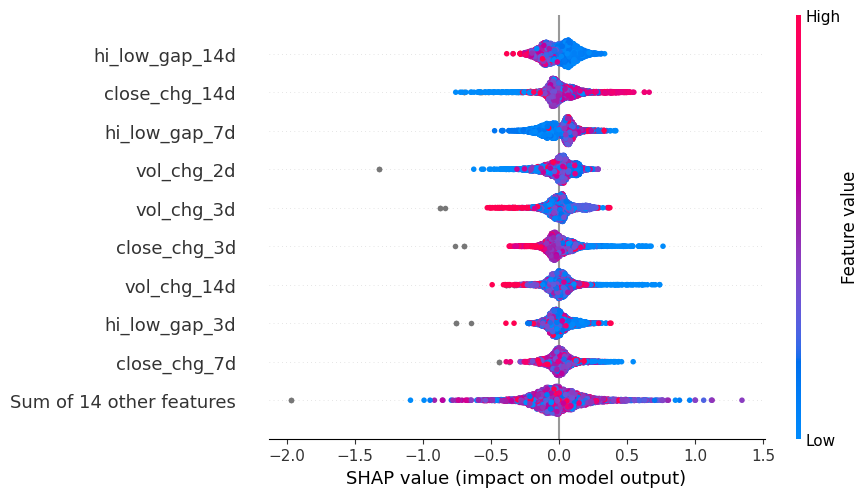

In [70]:
shap_explainer = shap.TreeExplainer(xgb_clf2)
shape_values = shap_explainer(X_train)
shap.plots.beeswarm(shap_values=shape_values)

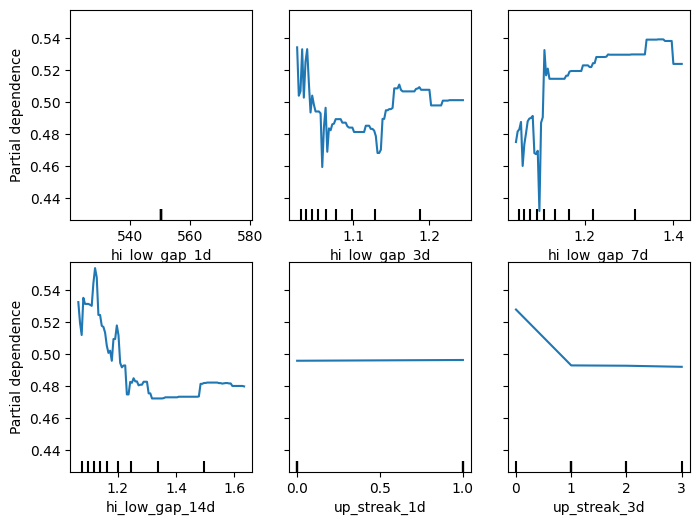

In [72]:
pdp = PartialDependenceDisplay.from_estimator(xgb_clf2, X_train, features=range(0, 6))
pdp.figure_.set_size_inches(8, 6)